## Transmitter

In [143]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from helperLibrary import (
    hard_decisions,
    StreamManagement,
    MyResourceGrid,
    Mapper,
    MyDemapper,
    MyResourceGridMapper,
    mygenerate_OFDMchannel,
    RemoveNulledSubcarriers,
    MyApplyOFDMChannel,
    MyApplyTimeChannel,
    OFDMModulator,
    OFDMDemodulator,
    BinarySource,
    ebnodb2no,
    complex_normal,
    time_lag_discrete_time_channel,
    cir_to_time_channel,
)

from sionna_tf import (
    MyLMMSEEqualizer,
)
from channel import (
    LSChannelEstimator,
)  # , time_lag_discrete_time_channel #, ApplyTimeChannel #cir_to_time_channel

from Encode_Decode.ldpc import LDPC5GDecoder, LDPC5GEncoder
# from NR_Receiver import NeuralReceiver


# # Define a fixed dataset class
# class FixedChannelDataset(Dataset):
#     def __init__(self, num_rx, num_tx, num_bits):
#         self.num_rx = num_rx
#         self.num_tx = num_tx
#         self.num_bits = num_bits
#         # Generate a fixed bit sequence
#         self.fixed_bits = np.array([1, 0, 1, 1, 0, 0, 1, 0] * (num_bits // 8 + 1))[
#             :num_bits
#         ]

#     def __len__(self):
#         return 1  # Only one data point

#     def __getitem__(self, idx):
#         h = np.ones((1, 1, 1, 16, 10, 1)) + 1j * np.ones((1, 1, 1, 16, 10, 1))
#         tau = np.full((1, 1, 10), 0.5)
#         return h, tau, self.fixed_bits


class RandomChannelDataset(Dataset):
    def __init__(self, num_rx, num_tx, num_bits):
        self.num_rx = num_rx
        self.num_tx = num_tx
        self.num_bits = num_bits

    def __len__(self):
        return 1  # Only one data point

    def __getitem__(self, idx):
        # Generate random channel gains and delays
        h = np.random.randn(1, 1, 1, 16, 10, 1) + 1j * np.random.randn(
            1, 1, 1, 16, 10, 1
        )
        tau = np.random.rand(1, 1, 10)
        # Generate random bits
        random_bits = np.random.randint(0, 2, self.num_bits)
        return h, tau, random_bits


class Transmitter(nn.Module):
    def __init__(
        self,
        num_rx=1,
        num_tx=1,
        batch_size=1,
        fft_size=76,
        num_ofdm_symbols=14,
        num_bits_per_symbol=4,
        subcarrier_spacing=15e3,
        num_guard_carriers=[15, 16],
        pilot_ofdm_symbol_indices=[2],
        USE_LDPC=True,
        pilot_pattern="kronecker",
        guards=True,
        showfig=True,
    ) -> None:
        self.fft_size = fft_size
        self.batch_size = batch_size
        self.num_bits_per_symbol = num_bits_per_symbol
        self.showfig = showfig
        self.pilot_pattern = pilot_pattern

        # Calculate the number of data symbols
        self.num_data_symbols = self.calculate_num_data_symbols(
            fft_size, num_ofdm_symbols, num_guard_carriers, pilot_ofdm_symbol_indices
        )
        # Calculate the codeword length (n) and number of information bits (k)
        self.n = self.num_data_symbols * num_bits_per_symbol
        self.k = self.calculate_k(self.n, USE_LDPC)
        # Use fixed channel data instead of random
        self.channeldataset = RandomChannelDataset(
            num_rx=num_rx, num_tx=num_tx, num_bits=self.k
        )

        # Load channel dataset using DataLoader with batch_size=1
        self.data_loader = DataLoader(
            dataset=self.channeldataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
        )

        h, tau, bits = next(iter(self.data_loader))  # Get the first batch of fixed channels
        print("h shape:", h.shape)
        print("tau shape:", tau.shape)
        # channels
        #         h shape: torch.Size([64, 1, 1, 1, 16, 10, 1])
        # tau shape: torch.Size([64, 1, 1, 10])
        print("h shape:", h.shape)
        print("tau shape:", tau.shape)

        # torch dataloaders
        self.data_loader = DataLoader(
            dataset=self.channeldataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
        )
        if showfig:
            self.plotchimpulse()

        # The number of transmitted streams is equal to the number of UT antennas
        # in both uplink and downlink
        # NUM_STREAMS_PER_TX = NUM_UT_ANT
        # NUM_UT_ANT = num_rx
        num_streams_per_tx = num_rx  ##1
        # Create an RX-TX association matrix.
        # RX_TX_ASSOCIATION[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. Depending on the transmission direction (uplink or downlink),
        # the role of UT and BS can change.
        # For example, considering a system with 2 RX and 4 TX, the RX-TX
        # association matrix could be
        # [ [1 , 1, 0, 0],
        #   [0 , 0, 1, 1] ]
        # which indicates that the RX 0 receives from TX 0 and 1, and RX 1 receives from
        # TX 2 and 3.
        #
        # we have only a single transmitter and receiver,
        # the RX-TX association matrix is simply:
        # RX_TX_ASSOCIATION = np.array([[1]]) #np.ones([num_rx, 1], int)
        RX_TX_ASSOCIATION = np.ones([num_rx, num_tx], int)  # [[1]]
        self.STREAM_MANAGEMENT = StreamManagement(
            RX_TX_ASSOCIATION, num_streams_per_tx
        )  # RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX

        if guards:
            cyclic_prefix_length = 6  # 0 #6 Length of the cyclic prefix
            if num_guard_carriers is None and type(num_guard_carriers) is not list:
                num_guard_carriers = [
                    5,
                    6,
                ]  # [0, 0] #List of two integers defining the number of guardcarriers at the left and right side of the resource grid.
            dc_null = True  # False
            if (
                pilot_ofdm_symbol_indices is None
                and type(pilot_ofdm_symbol_indices) is not list
            ):
                pilot_ofdm_symbol_indices = [2, 11]
        else:
            cyclic_prefix_length = 0  # 0 #6 Length of the cyclic prefix
            num_guard_carriers = [
                0,
                0,
            ]  # List of two integers defining the number of guardcarriers at the left and right side of the resource grid.
            dc_null = False
            pilot_ofdm_symbol_indices = [0, 0]
        # pilot_pattern = "kronecker" #"kronecker", "empty"
        # fft_size = 76
        # num_ofdm_symbols=14
        RESOURCE_GRID = MyResourceGrid(
            num_ofdm_symbols=num_ofdm_symbols,
            fft_size=fft_size,
            subcarrier_spacing=subcarrier_spacing,  # 60e3, #30e3,
            num_tx=num_tx,  # 1
            num_streams_per_tx=num_streams_per_tx,  # 1
            cyclic_prefix_length=cyclic_prefix_length,
            num_guard_carriers=num_guard_carriers,
            dc_null=dc_null,
            pilot_pattern=pilot_pattern,
            pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices,
        )
        if showfig:
            RESOURCE_GRID.show()  # 14(OFDM symbol)*76(subcarrier) array=1064
            RESOURCE_GRID.pilot_pattern.show()

        if showfig and pilot_pattern == "kronecker":

            plt.figure()
            plt.title("Real Part of the Pilot Sequences")
            for i in range(num_streams_per_tx):
                plt.stem(
                    np.real(RESOURCE_GRID.pilot_pattern.pilots[0, i]),
                    markerfmt="C{}.".format(i),
                    linefmt="C{}-".format(i),
                    label="Stream {}".format(i),
                )
            plt.legend()
        print(
            "Average energy per pilot symbol: {:1.2f}".format(
                np.mean(np.abs(RESOURCE_GRID.pilot_pattern.pilots[0, 0]) ** 2)
            )
        )
        self.num_streams_per_tx = num_streams_per_tx
        self.RESOURCE_GRID = RESOURCE_GRID

        # num_bits_per_symbol = 4
        # Codeword length
        n = int(
            RESOURCE_GRID.num_data_symbols * num_bits_per_symbol
        )  # num_data_symbols:64*14=896 896*4=3584, if empty 1064*4=4256

        # USE_LDPC = True
        if USE_LDPC:
            coderate = 0.5
            # Number of information bits per codeword
            k = int(n * coderate)
            encoder = LDPC5GEncoder(k, n)  # 1824, 3648
            decoder = LDPC5GDecoder(encoder, hard_out=True)
            self.decoder = decoder
            self.encoder = encoder
        else:
            coderate = 1
            # Number of information bits per codeword
            k = int(n * coderate)
        self.k = k  # Number of information bits per codeword
        self.USE_LDPC = USE_LDPC
        self.coderate = coderate

        self.mapper = Mapper("qam", num_bits_per_symbol)
        self.rg_mapper = MyResourceGridMapper(
            RESOURCE_GRID
        )  # ResourceGridMapper(RESOURCE_GRID)

        # receiver part
        self.mydemapper = MyDemapper(
            "app", constellation_type="qam", num_bits_per_symbol=num_bits_per_symbol
        )

    def plotchimpulse(self):
        h_b, tau_b = next(
            iter(self.data_loader)
        )  # h_b: [64, 1, 1, 1, 16, 10, 1], tau_b=[64, 1, 1, 10]
        # print(h_b.shape) #[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
        # print(tau_b.shape) #[batch, num_rx, num_tx, num_paths]
        tau_b = tau_b.numpy()  # torch tensor to numpy
        h_b = h_b.numpy()
        plt.figure()
        plt.title("Channel impulse response realization")
        plt.stem(
            tau_b[0, 0, 0, :] / 1e-9, np.abs(h_b)[0, 0, 0, 0, 0, :, 0]
        )  # 10 different pathes
        plt.xlabel(r"$\tau$ [ns]")
        plt.ylabel(r"$|a|$")

    def calculate_num_data_symbols(
        self, fft_size, num_ofdm_symbols, num_guard_carriers, pilot_ofdm_symbol_indices
    ):
        total_symbols = fft_size * num_ofdm_symbols
        guard_symbols = sum(num_guard_carriers) * num_ofdm_symbols
        pilot_symbols = len(pilot_ofdm_symbol_indices) * fft_size
        return total_symbols - guard_symbols - pilot_symbols

    def calculate_k(self, n, USE_LDPC):
        if USE_LDPC:
            coderate = 0.5
            # Number of information bits per codeword
            k = int(n * coderate)

        else:
            coderate = 1
            # Number of information bits per codeword
            k = int(n * coderate)
        return k    

    def generateChannel(self, x_rg, no, channeltype="ofdm"):
        # x_rg:[batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size][64,1,1,14,76]

        h_b, tau_b = self.get_htau_batch()
        h_out = None
        # print(h_b.shape) #complex (64, 1, 1, 1, 16, 10, 1)[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
        # print(tau_b.shape) #float (64, 1, 1, 10)[batch, num_rx, num_tx, num_paths]
        if channeltype == "ofdm":
            # Generate the OFDM channel response
            # computes the Fourier transform of the continuous-time channel impulse response at a set of `frequencies`, corresponding to the different subcarriers.
            ##h: [64, 1, 1, 1, 16, 10, 1], tau: [64, 1, 1, 10] => (64, 1, 1, 1, 16, 1, 76)
            h_freq = mygenerate_OFDMchannel(
                h_b,
                tau_b,
                self.fft_size,
                subcarrier_spacing=60000.0,
                dtype=np.complex64,
                normalize_channel=True,
            )
            print("h_freq.shape", h_freq.shape)
            # h_freq : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
            # (64, 1, 1, 1, 16, 1, 76)

            remove_nulled_scs = RemoveNulledSubcarriers(self.RESOURCE_GRID)
            h_out = remove_nulled_scs(h_freq)  # (64, 1, 1, 1, 16, 1, 64)
            if self.showfig:
                h_freq_plt = h_out[
                    0, 0, 0, 0, 0, 0
                ]  # get the last dimension: fft_size [76]
                # h_freq_plt = h_freq[0,0,0,0,0,0] #get the last dimension: fft_size [76]
                plt.figure()
                plt.plot(np.real(h_freq_plt))
                plt.plot(np.imag(h_freq_plt))
                plt.xlabel("Subcarrier index")
                plt.ylabel("Channel frequency response")
                plt.legend(["Ideal (real part)", "Ideal (imaginary part)"])
                plt.title("Comparison of channel frequency responses")

            # Generate the OFDM channel
            channel_freq = MyApplyOFDMChannel(add_awgn=True)
            # h_freq : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
            # (64, 1, 1, 1, 16, 1, 76)
            y = channel_freq([x_rg, h_freq, no])  # h_freq is array
            # Channel outputs y : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], complex
            # print(y.shape) #[64, 1, 1, 14, 76] dim (3,4 removed)

            # y = ApplyOFDMChannel(symbol_resourcegrid=x_rg, channel_frequency=h_freq, noiselevel=no, add_awgn=True)
            # y is the symbol received after the channel and noise
            # Channel outputs y : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], complex
        elif channeltype == "perfect":
            y = x_rg
        elif channeltype == "awgn":
            y = x_rg  # (64, 1, 1, 14, 76)
            noise = complex_normal(y.shape, var=1.0)
            print(noise.dtype)
            noise = noise.astype(y.dtype)
            noise *= np.sqrt(no)
            y = y + noise
        elif channeltype == "time":
            bandwidth = self.RESOURCE_GRID.bandwidth  # 4560000
            l_min, l_max = time_lag_discrete_time_channel(bandwidth)  # -6, 20
            l_tot = l_max - l_min + 1  # 27
            # Compute the discrete-time channel impulse reponse
            h_time = cir_to_time_channel(
                bandwidth, h_b, tau_b, l_min=l_min, l_max=l_max, normalize=True
            )
            # h_time: [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1] complex[64, 1, 1, 1, 16, 1, 27]
            h_out = h_time
            if self.showfig:
                plt.figure()
                plt.title("Discrete-time channel impulse response")
                plt.stem(np.abs(h_time[0, 0, 0, 0, 0, 0]))
                plt.xlabel(r"Time step $\ell$")
                plt.ylabel(r"$|\bar{h}|$")
            # channel_time = ApplyTimeChannel(self.RESOURCE_GRID.num_time_samples, l_tot=l_tot, add_awgn=False)
            channel_time = MyApplyTimeChannel(
                self.RESOURCE_GRID.num_time_samples, l_tot=l_tot, add_awgn=True
            )
            # OFDM modulator and demodulator
            modulator = OFDMModulator(self.RESOURCE_GRID.cyclic_prefix_length)
            demodulator = OFDMDemodulator(
                self.RESOURCE_GRID.fft_size,
                l_min,
                self.RESOURCE_GRID.cyclic_prefix_length,
            )

            # OFDM modulation with cyclic prefix insertion
            # x_rg:[batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size][64,1,1,14,76]
            x_time = modulator(x_rg)  # output: (64, 1, 1, 1064)
            # Compute the channel output
            # This computes the full convolution between the time-varying
            # discrete-time channel impulse reponse and the discrete-time
            # transmit signal. With this technique, the effects of an
            # insufficiently long cyclic prefix will become visible. This
            # is in contrast to frequency-domain modeling which imposes
            # no inter-symbol interfernce.
            y_time = channel_time([x_time, h_time, no])  # [64, 1, 1, 1174]
            # y_time = channel_time([x_time, h_time]) #(64, 1, 1, 1090) complex

            # Do modulator and demodulator test
            y_test = demodulator(x_time)
            differences = np.abs(x_rg - y_test)
            threshold = 1e-7
            num_differences = np.sum(differences > threshold)
            print("Number of differences:", num_differences)
            print(np.allclose(x_rg, y_test))
            print("Demodulation error (L2 norm):", np.linalg.norm(x_rg - y_test))

            # OFDM demodulation and cyclic prefix removal
            y = demodulator(y_time)
            # y = y_test
            # y: [64, 1, 1, 14, 76]
        return y, h_out

    def get_htau_batch(self, returnformat="numpy"):
        h_b, tau_b, bits = next(
            iter(self.data_loader)
        )  # h_b: [64, 1, 1, 1, 16, 10, 1], tau_b=[64, 1, 1, 10]
        # print(h_b.shape) #[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
        # print(tau_b.shape) #[batch, num_rx, num_tx, num_paths]
        if returnformat == "numpy":
            tau_b = tau_b.numpy()  # torch tensor to numpy
            h_b = h_b.numpy()
        return h_b, tau_b

    def __call__(self, b=None,ebno_db=15.0, channeltype="ofdm", perfect_csi=False):
        # Transmitter

        # if b is None:
        #     binary_source = BinarySource()
        #     # Start Transmitter self.k Number of information bits per codeword
        #     b = binary_source(
        #         [self.batch_size, 1, self.num_streams_per_tx, self.k]
        #     ) # b shape: (64, 1, 1, 2288)
        if b is None:
            # Assign a fixed value to b
            fixed_value = 1  # or 0, or any other value you want
            b = np.full([self.batch_size, 1, self.num_streams_per_tx, self.k], fixed_value, dtype=np.float32)
        print("b shape:", b.shape, "btype:", type(b))
        c = self.encoder(b) if self.USE_LDPC else b
        x = self.mapper(
            c
        )  # np.array[64,1,1,896] if empty np.array[64,1,1,1064] 1064*4=4256 [batch_size, num_tx, num_streams_per_tx, num_data_symbols]
        print("x shape:", x.shape, "xtype:", type(x))
        # Add these checks and conversions
        x = np.array(x)  # Ensure x is a numpy array
        expected_shape = (self.batch_size, 1, self.num_streams_per_tx, self.RESOURCE_GRID.num_data_symbols)
        if x.shape != expected_shape:
            raise ValueError(f"Expected shape {expected_shape}, but got {x.shape}")

        # Ensure the dtype is complex64 or complex128
        x = x.astype(np.complex64)
        x_rg = self.rg_mapper(x)  ##complex array[64,1,1,14,76] 14*76=1064
        # output: [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size][64,1,1,14,76]

        # no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, RESOURCE_GRID)
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        # Convert it to a NumPy float
        no = np.float32(no)  # 0.0158

        y, h_out = self.generateChannel(x_rg, no, channeltype=channeltype)
        # y is the symbol received after the channel and noise
        # Channel outputs y : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], complex
        y = np.array(y)
        h_out = np.array(h_out)
        print("no:", no)
        return y, h_out, b, no

## Baseline receiver

In [7]:
class BaselineReceiver(nn.Module):
    """Baseline receiver with LS channel estimation and LMMSE equalization."""

    def __init__(self, resource_grid, stream_management, demapper):
        self.resource_grid = resource_grid
        self.stream_management = stream_management
        self.demapper = demapper

    def __call__(self, y, h_out, no, perfect_csi=False):
        if perfect_csi:
            h_hat, err_var = h_out, 0.0
        else:
            ls_est = LSChannelEstimator(
                self.resource_grid, interpolation_type="lin_time_avg"
            )
            y = np.array(y)
            no = np.array(no)
            print("y shape:", y.shape, "ytype:", type(y))
            print("no shape:", no.shape, "notype:", type(no))
            h_hat, err_var = ls_est([y, no])

        lmmse_equ = MyLMMSEEqualizer(self.resource_grid, self.stream_management)
        x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
        x_hat = x_hat.numpy()  # (64, 1, 1, 912)
        no_eff = no_eff.numpy()  # (64, 1, 1, 912)
        no_eff = np.mean(no_eff)

        llr_est = self.demapper([x_hat, no_eff])
        # llr_est #(64, 1, 1, 4256)

        b_hat = hard_decisions(llr_est, np.int32)
        # BER = calculate_BER(b, b_hat)
        # print("BER Value:", BER)
        return b_hat

## neuralreceiver_old

## current neural receiver

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class NeuralReceiver(nn.Module):
    def __init__(
        self,
        resource_grid,
        stream_management,
        num_bits_per_symbol=4,
        num_rx_ant=1,
        num_tx=1,
    ):
        super(NeuralReceiver, self).__init__()
        self.resource_grid = resource_grid
        self.stream_management = stream_management
        self.num_bits_per_symbol = num_bits_per_symbol
        self.num_rx_ant = num_rx_ant
        self.num_tx = num_tx

        # Channel estimator (CNN)
        self.channel_estimator = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
        )

        # Equalizer (CNN)
        self.equalizer = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
        )

        # Demapper (Fully connected layer)
        self.demapper = nn.Linear(2, num_bits_per_symbol)

        # Create the data mask
        self.create_data_mask()

    def create_data_mask(self):
        num_ofdm_symbols = self.resource_grid.num_ofdm_symbols
        fft_size = self.resource_grid.fft_size
        data_mask = np.ones((num_ofdm_symbols, fft_size), dtype=bool)

        # Set guard subcarriers to False
        left_guard, right_guard = self.resource_grid.num_guard_carriers
        data_mask[:, :left_guard] = False
        data_mask[:, -right_guard:] = False

        # Set DC null to False
        if self.resource_grid.dc_null:
            data_mask[:, fft_size // 2] = False

        # Set pilot positions to False
        pilot_pattern = self.resource_grid.pilot_pattern
        pilot_ofdm_symbol_indices = pilot_pattern.pilot_ofdm_symbol_indices
        for symbol_idx in pilot_ofdm_symbol_indices:
            data_mask[symbol_idx, :] = False

        self.data_mask_flat = torch.from_numpy(data_mask.flatten())

    def forward(self, y):
        # Convert numpy array to PyTorch tensor
        if not isinstance(y, torch.Tensor):
            # Convert numpy array to PyTorch tensor
            y = torch.from_numpy(y).to(torch.complex64)
        else:
            # Ensure y is of type complex64
            y = y.to(torch.complex64)

        batch_size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size = y.shape

        # Now you can safely access real and imaginary parts
        y_input = torch.cat([y.real, y.imag], dim=2)
        y_input = y_input.view(batch_size, -1, num_ofdm_symbols, fft_size)

        # Channel estimation
        h_est = self.channel_estimator(y_input)

        # Prepare input for equalizer
        equalizer_input = torch.cat([y_input, h_est], dim=1)

        # Equalization
        x_est = self.equalizer(equalizer_input)

        # Reshape for demapping
        x_est = x_est.permute(0, 2, 3, 1).contiguous()
        x_est = x_est.view(batch_size, -1, 2)

        # Apply data mask
        x_est_data = x_est[:, self.data_mask_flat, :]

        # Demapping
        llr_est = self.demapper(x_est_data)

        # Reshape to match expected output
        llr_est = llr_est.view(batch_size, 1, 1, -1)

        return llr_est
 

## train neural receiver

In [36]:
def train_neural_receiver(
    transmitter, neural_receiver, num_epochs, batch_size, learning_rate
):
    optimizer = optim.Adam(neural_receiver.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for _ in range(100):  # Train on 100 batches per epoch
            # Generate a batch of data using the transmitter
            y, h_out, b, no = transmitter(ebno_db=5.0, channeltype="ofdm", perfect_csi=False)

            # Convert numpy arrays to PyTorch tensors
            y_tensor = torch.from_numpy(y).float()
            b_tensor = torch.from_numpy(b).float()

            # Forward pass
            b_hat = neural_receiver(y_tensor)

            # Compute loss
            loss = criterion(b_hat, b_tensor)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/100:.4f}")

    print("Finished Training")


def calculate_BER(bits, bits_est):
    errors = (bits != bits_est).sum()
    N = len(bits.flatten())
    BER = 1.0 * errors / N

    return BER


# Function to evaluate BER
def evaluate_ber(transmitter, neural_receiver):
    y, h_out, b, no = transmitter(ebno_db=5.0, channeltype="ofdm", perfect_csi=False)
    y_tensor = torch.from_numpy(y).float()
    b_hat = neural_receiver(y_tensor)
    b_hat_numpy = (b_hat.detach().cpu().numpy() > 0.5).astype(int)
    ber = calculate_BER(b, b_hat_numpy)
    print(f"Bit Error Rate (BER): {ber:.6f}")

## random dataset

## calculate ber

In [12]:
def calculate_BER(bits, bits_est):
    errors = (bits != bits_est).sum()
    N = len(bits.flatten())
    BER = 1.0 * errors / N

    return BER

## Demo Test main

In [144]:
if __name__ == "__main__":
    showfigure = False
    transmitter = Transmitter(
        num_rx=1,
        num_tx=1,
        batch_size=64,
        fft_size=76,
        num_ofdm_symbols=14,
        num_bits_per_symbol=4,
        subcarrier_spacing=60e3,
        USE_LDPC=False,
        pilot_pattern="kronecker",
        guards=True,
        showfig=showfigure,
    )  # "kronecker" "empty"


    # channeltype="perfect", "awgn", "ofdm", "time"
    y, h_out, b, no = transmitter(ebno_db=5.0, channeltype="ofdm", perfect_csi=False)

h shape: torch.Size([1, 1, 1, 1, 16, 10, 1])
tau shape: torch.Size([1, 1, 1, 10])
h shape: torch.Size([1, 1, 1, 1, 16, 10, 1])
tau shape: torch.Size([1, 1, 1, 10])
Average energy per pilot symbol: 1.00
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.07905694


## Training and saving the best model

In [108]:
import torch
import torch.optim as optim
import torch.nn.functional as F


neural_receiver = NeuralReceiver(
    resource_grid=transmitter.RESOURCE_GRID,
    stream_management=transmitter.STREAM_MANAGEMENT,
    num_bits_per_symbol=transmitter.num_bits_per_symbol,
    num_rx_ant=1,
    num_tx=1,
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(neural_receiver.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
num_epochs = 100
patience = 10
best_loss = float("inf")
early_stop_counter = 0

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    # Generate fixed input bits
    fixed_value = 1  # or 0, or any other value you want
    b = np.full(
        [transmitter.batch_size, 1, transmitter.num_streams_per_tx, transmitter.k],
        fixed_value,
        dtype=np.float32,
    )

    # Pass through transmitter
    y, h_out, b, no = transmitter(b=b, ebno_db=15.0, channeltype="ofdm")

    # Convert y to PyTorch tensor
    y_tensor = torch.from_numpy(y).to(torch.complex64)

    # Pass through neural receiver
    llr_est = neural_receiver(y_tensor)

    # Compute loss
    b_tensor = torch.from_numpy(b).float()
    loss = criterion(llr_est.view(-1), b_tensor.view(-1))

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    predictions = (llr_est.view(-1) > 0).float()
    correct += (predictions == b_tensor.view(-1)).sum().item()
    total += b_tensor.numel()

    total_loss += loss.item()

    # Early stopping check
    if total_loss < best_loss:
        best_loss = total_loss
        early_stop_counter = 0
        torch.save(neural_receiver.state_dict(), "best_neural_receiver_model.pth")
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

    # Print epoch statistics
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {100*correct/total:.2f}%"
    )

# Load the best model after training is complete
neural_receiver.load_state_dict(torch.load("best_neural_receiver_model.pth"))

b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
Epoch [1/100], Loss: 0.9559, Accuracy: 45.78%
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
Epoch [2/100], Loss: 0.1870, Accuracy: 97.43%
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
Epoch [3/100], Loss: 0.0644, Accuracy: 99.40%
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
Epoch [4/100], Loss: 0.0220, Accuracy: 100.00%
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 

<All keys matched successfully>

In [132]:
# Load the trained model
neural_receiver.load_state_dict(torch.load("best_neural_receiver_model.pth"))
neural_receiver.eval()  # Set the model to evaluation mode

NeuralReceiver(
  (channel_estimator): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (equalizer): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (demapper): Linear(in_features=2, out_features=4, bias=True)
)

## Testing accuracy of trained model

In [145]:
y_tensor = torch.from_numpy(y).to(torch.complex64)
with torch.no_grad():
    llr_est = neural_receiver(y_tensor)


b_tensor = torch.from_numpy(b).float()
predictions = (llr_est.view(-1) > 0).float()
correct = (predictions == b_tensor.view(-1)).sum().item()
total = b_tensor.numel()

accuracy = 100 * correct / total
ber = 1 - (correct / total)

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Bit Error Rate: {ber:.4f}")

Test Accuracy: 100.00%
Bit Error Rate: 0.0000


## Train model on different SNR(range from 0 to 7)


In [113]:
# Define loss function and optimizer with weight decay
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(neural_receiver.parameters(), lr=0.001, weight_decay=1e-5)

# Define SNR range based on the plot
snr_range = np.arange(0, 8, 1)  # SNR values from 0 to 7 dB

# Training loop with early stopping
num_epochs = 100
patience = 10
best_loss = float("inf")
early_stop_counter = 0

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for snr_db in snr_range:
        # Generate fixed input bits
        fixed_value = 1  # or 0, or any other value you want
        b = np.full(
            [transmitter.batch_size, 1, transmitter.num_streams_per_tx, transmitter.k],
            fixed_value,
            dtype=np.float32,
        )

        # Pass through transmitter with varying SNR
        y, h_out, b, no = transmitter(b=b, ebno_db=snr_db, channeltype="ofdm")

        # Convert y to PyTorch tensor
        y_tensor = torch.from_numpy(y).to(torch.complex64)

        # Pass through neural receiver
        llr_est = neural_receiver(y_tensor)

        # Compute loss
        b_tensor = torch.from_numpy(b).float()
        loss = criterion(llr_est.view(-1), b_tensor.view(-1))

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        predictions = (llr_est.view(-1) > 0).float()
        correct += (predictions == b_tensor.view(-1)).sum().item()
        total += b_tensor.numel()

        total_loss += loss.item()

    # Early stopping check
    if total_loss < best_loss:
        best_loss = total_loss
        early_stop_counter = 0
        torch.save(neural_receiver.state_dict(), "best_neural_receiver_model.pth")
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

    # Print epoch statistics
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {100*correct/total:.2f}%"
    )

# Load the best model after training is complete
neural_receiver.load_state_dict(torch.load("best_neural_receiver_model.pth"))

b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64,

<All keys matched successfully>

In [146]:
def ber_calculate(llr_est, b):
    """
    Calculate the Bit Error Rate (BER).

    Parameters:
    - llr_est: Log-likelihood ratio estimates from the neural receiver.
    - b: Actual bits transmitted.

    Returns:
    - ber: The calculated bit error rate.
    """
    # Convert actual bits to a PyTorch tensor
    b_tensor = torch.from_numpy(b).float()

    # Compute predictions from LLR estimates
    predictions = (llr_est.view(-1) > 0).float()

    # Calculate number of correct predictions
    correct = (predictions == b_tensor.view(-1)).sum().item()

    # Total number of bits
    total = b_tensor.numel()

    # Compute BER
    ber = 1 - (correct / total)

    return ber

In [147]:
# SNR range for evaluation
snr_range = np.arange(0, 15, 1)
ber_results = []
ber_baseline_results = []
for snr_db in snr_range:
    # Generate fixed input bits
    fixed_value = 1  # or 0, or any other value you want
    b = np.full(
        [transmitter.batch_size, 1, transmitter.num_streams_per_tx, transmitter.k],
        fixed_value,
        dtype=np.float32,
    )

    # Pass through transmitter with varying SNR
    y, h_out, b, no = transmitter(b=b, ebno_db=snr_db, channeltype="ofdm")


    b_hat1 = baseline_receiver(y, h_out, no)
    berr1 = calculate_BER(b, b_hat1)
    ber_baseline_results.append(berr1)
    # Convert y to PyTorch tensor
    y_tensor = torch.from_numpy(y).to(torch.complex64)

    # Pass through neural receiver
    with torch.no_grad():
        llr_est = neural_receiver(y_tensor)

    # Calculate BER using the function
    ber = ber_calculate(llr_est, b)
    ber_results.append(ber)

    print(f"SNR: {snr_db} dB, Bit Error Rate: {ber:.4f}")



print("ber_results",ber_results)
print("BER Comparison:")
print("SNR (dB) | Baseline BER | Neural Receiver BER")
print("---------|--------------|-----------------")
for snr, baseline_ber, neural_ber in zip(snr_range, ber_baseline_results, ber_results):
    print(f"{snr:8.1f} | {baseline_ber:.6f}    | {neural_ber:.6f}")




b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.25
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
SNR: 0 dB, Bit Error Rate: 0.0000
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.19858205
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
SNR: 1 dB, Bit Error Rate: 0.0000
b shape: (64, 1, 1, 2288) btype: <class 'numpy.ndarray'>
x shape: (64, 1, 1, 572) xtype: <class 'numpy.ndarray'>
h_freq.shape (1, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.15773934
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
SNR: 2 dB, Bit Error Rate: 0.0000
b shape: (64, 1, 1, 2288) btype: <cla

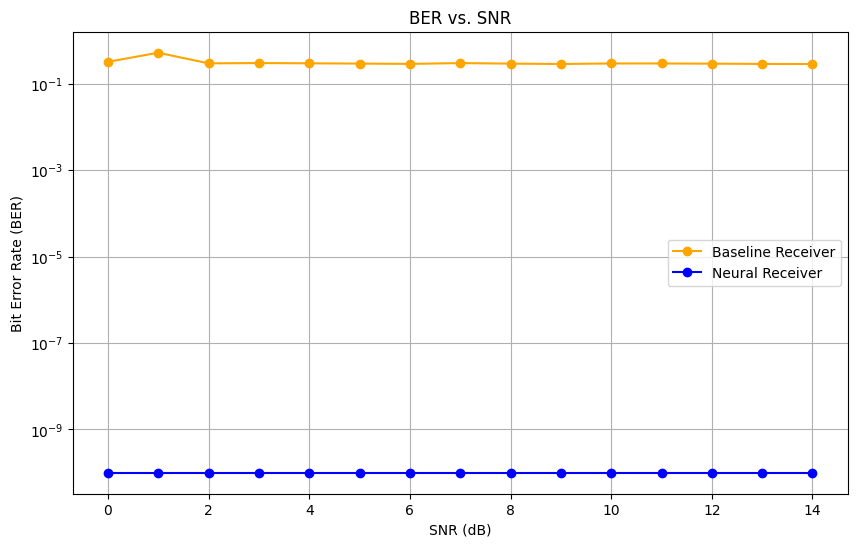

In [148]:
# Plotting
# Add a small offset to zero BER values for visibility on log scale
ber_results_with_offset = [max(ber, 1e-10) for ber in ber_results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    snr_range,
    ber_baseline_results,
    marker="o",
    label="Baseline Receiver",
    color="orange",
)
plt.plot(
    snr_range,
    ber_results_with_offset,
    marker="o",
    label="Neural Receiver",
    color="blue",
)

plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs. SNR")
plt.yscale("log")  # Use log scale for better visibility of BER differences
plt.grid(True)
plt.legend()
plt.show()